In [2]:
# Ensure `torchsummary` is installed and importable (fallback to `torchinfo`)
import importlib, subprocess, sys


def ensure_package(pkg_name: str, import_name: str = None):
    name = import_name or pkg_name
    try:
        return importlib.import_module(name)
    except Exception:
        print(f"⚠️ {name} not found — installing {pkg_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
        importlib.invalidate_caches()
        module = importlib.import_module(name)
        print(f"✅ Installed and imported {name}")
        return module

# Primary: torchsummary
try:
    ts = ensure_package("torchsummary", "torchsummary")
    from torchsummary import summary
    print("✅ `torchsummary.summary` is available")
except Exception as e:
    print("⚠️ Failed to import `torchsummary` (will try fallback):", e)
    # Fallback: torchinfo
    try:
        ti = ensure_package("torchinfo", "torchinfo")
        from torchinfo import summary
        print("✅ Using fallback `torchinfo.summary`")
    except Exception as e2:
        print("❌ Failed to install fallback 'torchinfo':", e2)
        print("Please install `torchsummary` or `torchinfo` in your environment and re-run this cell.")

⚠️ torchsummary not found — installing torchsummary...
✅ Installed and imported torchsummary
✅ `torchsummary.summary` is available


## 1. Import Libraries

In [3]:
# Standard libraries
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torchsummary import summary

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Configuration

In [4]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
output_dir = project_root / 'outputs' / 'model_architecture'
output_dir.mkdir(parents=True, exist_ok=True)

# Load dataset configuration
with open(project_root / 'outputs' / 'dataset' / 'dataset_config.json', 'r') as f:
    dataset_config = json.load(f)

print(f"📁 Project Root: {project_root}")
print(f"📁 Output Directory: {output_dir}")
print(f"\n✅ Loaded dataset configuration")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

# Model configuration
model_config = {
    'input_channels': 41,  # 3 CA + 18 Pose + 20 Parsing
    'output_channels': 3,  # RGB
    'image_size': (1024, 768),
    'ngf': 64,  # Generator base channels
    'ndf': 64,  # Discriminator base channels
    'n_downsampling': 4,
    'n_blocks': 9,  # Residual blocks at bottleneck
    'use_dropout': True,
    'use_attention': True
}

print(f"\n📊 Model Configuration:")
for key, value in model_config.items():
    print(f"   {key}: {value}")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\model_architecture

✅ Loaded dataset configuration

🖥️ Using device: cuda

📊 Model Configuration:
   input_channels: 41
   output_channels: 3
   image_size: (1024, 768)
   ngf: 64
   ndf: 64
   n_downsampling: 4
   n_blocks: 9
   use_dropout: True
   use_attention: True


## 3. Building Blocks

Define reusable components for the networks.

In [5]:
class ResidualBlock(nn.Module):
    """
    Residual block with two convolutional layers.
    """
    def __init__(self, channels: int, use_dropout: bool = False):
        super().__init__()
        
        layers = [
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True)
        ]
        
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        
        layers += [
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        ]
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.block(x)


class SelfAttention(nn.Module):
    """
    Self-attention module for capturing long-range dependencies.
    """
    def __init__(self, channels: int):
        super().__init__()
        
        self.query = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch, channels, height, width = x.size()
        
        # Query, Key, Value
        q = self.query(x).view(batch, -1, height * width).permute(0, 2, 1)
        k = self.key(x).view(batch, -1, height * width)
        v = self.value(x).view(batch, -1, height * width)
        
        # Attention map
        attention = F.softmax(torch.bmm(q, k), dim=-1)
        
        # Apply attention
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(batch, channels, height, width)
        
        return self.gamma * out + x


class DownsampleBlock(nn.Module):
    """
    Downsampling block for encoder.
    """
    def __init__(self, in_channels: int, out_channels: int, 
                 normalize: bool = True, dropout: float = 0.0):
        super().__init__()
        
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, 
                     stride=2, padding=1, bias=False)
        ]
        
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class UpsampleBlock(nn.Module):
    """
    Upsampling block for decoder with skip connections.
    """
    def __init__(self, in_channels: int, out_channels: int, dropout: float = 0.0):
        super().__init__()
        
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        
        self.block = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, skip: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.block(x)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        return x


print("✅ Building blocks defined:")
print("   - ResidualBlock")
print("   - SelfAttention")
print("   - DownsampleBlock")
print("   - UpsampleBlock")

✅ Building blocks defined:
   - ResidualBlock
   - SelfAttention
   - DownsampleBlock
   - UpsampleBlock


## 4. Generator Network

U-Net architecture with attention and residual connections.

In [6]:
class Generator(nn.Module):
    """
    U-Net based Generator for Virtual Try-On.
    
    Input: [B, 41, H, W] (cloth-agnostic + pose + parsing)
    Output: [B, 3, H, W] (RGB image)
    """
    
    def __init__(self, 
                 in_channels: int = 41,
                 out_channels: int = 3,
                 ngf: int = 64,
                 n_downsampling: int = 4,
                 n_blocks: int = 9,
                 use_dropout: bool = True,
                 use_attention: bool = True):
        super().__init__()
        
        self.n_downsampling = n_downsampling
        
        # Initial convolution
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, ngf, kernel_size=7, padding=3, bias=False),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True)
        )
        
        # Encoder (downsampling)
        self.encoder = nn.ModuleList()
        mult = 1
        for i in range(n_downsampling):
            mult_prev = mult
            mult = min(2 ** (i + 1), 8)
            self.encoder.append(
                DownsampleBlock(
                    ngf * mult_prev,
                    ngf * mult,
                    normalize=True,
                    dropout=0.0
                )
            )
        
        # Bottleneck (residual blocks)
        bottleneck_channels = ngf * mult
        self.bottleneck = nn.ModuleList()
        for _ in range(n_blocks):
            self.bottleneck.append(
                ResidualBlock(bottleneck_channels, use_dropout=use_dropout)
            )
        
        # Self-attention at bottleneck
        self.attention = SelfAttention(bottleneck_channels) if use_attention else None
        
        # Decoder (upsampling)
        self.decoder = nn.ModuleList()
        for i in range(n_downsampling):
            mult_prev = min(2 ** (n_downsampling - i), 8)
            mult = min(2 ** (n_downsampling - i - 1), 8)
            
            # Account for skip connections (double the input channels)
            in_ch = ngf * mult_prev
            out_ch = ngf * mult
            
            self.decoder.append(
                UpsampleBlock(
                    in_ch * 2,  # *2 for skip connection
                    out_ch,
                    dropout=0.5 if i < 3 and use_dropout else 0.0
                )
            )
        
        # Final convolution
        self.final = nn.Sequential(
            nn.Conv2d(ngf * 2, ngf, kernel_size=3, padding=1, bias=False),  # *2 for skip
            nn.InstanceNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.Conv2d(ngf, out_channels, kernel_size=7, padding=3),
            nn.Tanh()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through Generator.
        
        Args:
            x: Input tensor [B, 41, H, W]
        
        Returns:
            Generated image [B, 3, H, W]
        """
        # Initial convolution
        x = self.initial(x)
        
        # Encoder with skip connections
        skip_connections = [x]
        for encoder_block in self.encoder:
            x = encoder_block(x)
            skip_connections.append(x)
        
        # Bottleneck
        for res_block in self.bottleneck:
            x = res_block(x)
        
        # Attention
        if self.attention is not None:
            x = self.attention(x)
        
        # Decoder with skip connections
        skip_connections = skip_connections[::-1]  # Reverse order
        for i, decoder_block in enumerate(self.decoder):
            skip = skip_connections[i]
            x = torch.cat([x, skip], dim=1)
            x = decoder_block(x)
        
        # Final convolution with last skip connection
        x = torch.cat([x, skip_connections[-1]], dim=1)
        x = self.final(x)
        
        return x


print("✅ Generator network defined")
print("   Architecture: U-Net with attention")
print("   Input: [B, 41, H, W]")
print("   Output: [B, 3, H, W]")

✅ Generator network defined
   Architecture: U-Net with attention
   Input: [B, 41, H, W]
   Output: [B, 3, H, W]


## 5. Discriminator Network

PatchGAN discriminator with spectral normalization.

In [7]:
class Discriminator(nn.Module):
    """
    PatchGAN Discriminator for Virtual Try-On.
    
    Classifies 70x70 patches as real or fake.
    Uses spectral normalization for training stability.
    """
    
    def __init__(self,
                 in_channels: int = 6,  # 3 (image) + 3 (condition)
                 ndf: int = 64,
                 n_layers: int = 3,
                 use_spectral_norm: bool = True):
        super().__init__()
        
        norm_layer = spectral_norm if use_spectral_norm else lambda x: x
        
        # Initial layer (no normalization)
        layers = [
            norm_layer(nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Intermediate layers
        mult = 1
        for n in range(1, n_layers):
            mult_prev = mult
            mult = min(2 ** n, 8)
            layers += [
                norm_layer(nn.Conv2d(ndf * mult_prev, ndf * mult, 
                                    kernel_size=4, stride=2, padding=1, bias=False)),
                nn.InstanceNorm2d(ndf * mult),
                nn.LeakyReLU(0.2, inplace=True)
            ]
        
        # Final layers
        mult_prev = mult
        mult = min(2 ** n_layers, 8)
        layers += [
            norm_layer(nn.Conv2d(ndf * mult_prev, ndf * mult,
                                kernel_size=4, stride=1, padding=1, bias=False)),
            nn.InstanceNorm2d(ndf * mult),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        
        # Output layer
        layers.append(
            norm_layer(nn.Conv2d(ndf * mult, 1, kernel_size=4, stride=1, padding=1))
        )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through Discriminator.
        
        Args:
            x: Input image [B, 3, H, W]
            condition: Condition image [B, 3, H, W] (e.g., cloth-agnostic)
        
        Returns:
            Patch predictions [B, 1, H', W']
        """
        # Concatenate image and condition
        x = torch.cat([x, condition], dim=1)
        return self.model(x)


print("✅ Discriminator network defined")
print("   Architecture: PatchGAN with spectral normalization")
print("   Input: [B, 6, H, W] (image + condition)")
print("   Output: [B, 1, H', W'] (patch predictions)")

✅ Discriminator network defined
   Architecture: PatchGAN with spectral normalization
   Input: [B, 6, H, W] (image + condition)
   Output: [B, 1, H', W'] (patch predictions)


## 6. Initialize Models

In [8]:
# Initialize Generator
generator = Generator(
    in_channels=model_config['input_channels'],
    out_channels=model_config['output_channels'],
    ngf=model_config['ngf'],
    n_downsampling=model_config['n_downsampling'],
    n_blocks=model_config['n_blocks'],
    use_dropout=model_config['use_dropout'],
    use_attention=model_config['use_attention']
).to(device)

# Initialize Discriminator
discriminator = Discriminator(
    in_channels=6,  # RGB image + RGB condition
    ndf=model_config['ndf'],
    n_layers=3,
    use_spectral_norm=True
).to(device)

print("="*70)
print("🎯 MODELS INITIALIZED")
print("="*70)
print(f"\n✅ Generator created and moved to {device}")
print(f"✅ Discriminator created and moved to {device}")

🎯 MODELS INITIALIZED

✅ Generator created and moved to cuda
✅ Discriminator created and moved to cuda


## 7. Count Parameters

In [9]:
def count_parameters(model: nn.Module) -> Tuple[int, int]:
    """
    Count total and trainable parameters.
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


# Count parameters
gen_total, gen_trainable = count_parameters(generator)
disc_total, disc_trainable = count_parameters(discriminator)

print("="*70)
print("📊 PARAMETER COUNT")
print("="*70)

print(f"\n🔷 Generator:")
print(f"   Total parameters: {gen_total:,}")
print(f"   Trainable parameters: {gen_trainable:,}")
print(f"   Memory: {gen_total * 4 / 1024**2:.2f} MB (float32)")

print(f"\n🔶 Discriminator:")
print(f"   Total parameters: {disc_total:,}")
print(f"   Trainable parameters: {disc_trainable:,}")
print(f"   Memory: {disc_total * 4 / 1024**2:.2f} MB (float32)")

print(f"\n📊 Total:")
print(f"   Combined parameters: {gen_total + disc_total:,}")
print(f"   Combined memory: {(gen_total + disc_total) * 4 / 1024**2:.2f} MB")

print("\n" + "="*70)

📊 PARAMETER COUNT

🔷 Generator:
   Total parameters: 63,847,812
   Trainable parameters: 63,847,812
   Memory: 243.56 MB (float32)

🔶 Discriminator:
   Total parameters: 2,766,913
   Trainable parameters: 2,766,913
   Memory: 10.55 MB (float32)

📊 Total:
   Combined parameters: 66,614,725
   Combined memory: 254.12 MB



## 8. Test Forward Pass - Generator

In [10]:
print("="*70)
print("🧪 TESTING GENERATOR FORWARD PASS")
print("="*70)

# Create dummy input
batch_size = 2
dummy_input = torch.randn(batch_size, 41, 1024, 768).to(device)

print(f"\n📥 Input shape: {tuple(dummy_input.shape)}")
print(f"   Channels breakdown:")
print(f"   - Cloth-agnostic RGB: 3")
print(f"   - Pose heatmaps: 18")
print(f"   - Parsing one-hot: 20")
print(f"   Total: 41 channels")

# Forward pass
generator.eval()
with torch.no_grad():
    output = generator(dummy_input)

print(f"\n📤 Output shape: {tuple(output.shape)}")
print(f"   Output range: [{output.min().item():.3f}, {output.max().item():.3f}]")
print(f"   Expected range: [-1, 1] (Tanh activation)")

# Check output
assert output.shape == (batch_size, 3, 1024, 768), "Output shape mismatch!"
assert output.min() >= -1.0 and output.max() <= 1.0, "Output range incorrect!"

print(f"\n✅ Generator forward pass successful!")
print(f"   Input: {tuple(dummy_input.shape)}")
print(f"   Output: {tuple(output.shape)}")

# Memory usage
if torch.cuda.is_available():
    mem_allocated = torch.cuda.memory_allocated() / 1024**2
    mem_reserved = torch.cuda.memory_reserved() / 1024**2
    print(f"\n💾 GPU Memory:")
    print(f"   Allocated: {mem_allocated:.2f} MB")
    print(f"   Reserved: {mem_reserved:.2f} MB")

print("\n" + "="*70)

🧪 TESTING GENERATOR FORWARD PASS

📥 Input shape: (2, 41, 1024, 768)
   Channels breakdown:
   - Cloth-agnostic RGB: 3
   - Pose heatmaps: 18
   - Parsing one-hot: 20
   Total: 41 channels

📤 Output shape: (2, 3, 1024, 768)
   Output range: [-0.960, 0.915]
   Expected range: [-1, 1] (Tanh activation)

✅ Generator forward pass successful!
   Input: (2, 41, 1024, 768)
   Output: (2, 3, 1024, 768)

💾 GPU Memory:
   Allocated: 527.31 MB
   Reserved: 4258.00 MB



## 9. Test Forward Pass - Discriminator

In [11]:
print("="*70)
print("🧪 TESTING DISCRIMINATOR FORWARD PASS")
print("="*70)

# Create dummy inputs
dummy_image = torch.randn(batch_size, 3, 1024, 768).to(device)
dummy_condition = torch.randn(batch_size, 3, 1024, 768).to(device)

print(f"\n📥 Input shapes:")
print(f"   Image: {tuple(dummy_image.shape)}")
print(f"   Condition: {tuple(dummy_condition.shape)}")

# Forward pass
discriminator.eval()
with torch.no_grad():
    disc_output = discriminator(dummy_image, dummy_condition)

print(f"\n📤 Output shape: {tuple(disc_output.shape)}")
print(f"   Output range: [{disc_output.min().item():.3f}, {disc_output.max().item():.3f}]")

# Calculate receptive field size
patch_h, patch_w = disc_output.shape[2], disc_output.shape[3]
print(f"\n📊 Patch predictions:")
print(f"   Number of patches: {patch_h} × {patch_w} = {patch_h * patch_w}")
print(f"   Each patch covers ~70×70 pixels")

print(f"\n✅ Discriminator forward pass successful!")
print(f"   Image: {tuple(dummy_image.shape)}")
print(f"   Condition: {tuple(dummy_condition.shape)}")
print(f"   Output: {tuple(disc_output.shape)}")

print("\n" + "="*70)

🧪 TESTING DISCRIMINATOR FORWARD PASS

📥 Input shapes:
   Image: (2, 3, 1024, 768)
   Condition: (2, 3, 1024, 768)

📤 Output shape: (2, 1, 126, 94)
   Output range: [-1043.094, 820.921]

📊 Patch predictions:
   Number of patches: 126 × 94 = 11844
   Each patch covers ~70×70 pixels

✅ Discriminator forward pass successful!
   Image: (2, 3, 1024, 768)
   Condition: (2, 3, 1024, 768)
   Output: (2, 1, 126, 94)



## 10. Test Full Pipeline

In [12]:
print("="*70)
print("🔄 TESTING FULL PIPELINE")
print("="*70)

# Create dummy input
print("\n📥 Creating dummy inputs...")
multi_channel_input = torch.randn(batch_size, 41, 1024, 768).to(device)
real_image = torch.randn(batch_size, 3, 1024, 768).to(device)
condition = torch.randn(batch_size, 3, 1024, 768).to(device)

# Generator forward pass
print("\n🔷 Generator: Generating fake images...")
generator.eval()
with torch.no_grad():
    fake_image = generator(multi_channel_input)

print(f"   Input: {tuple(multi_channel_input.shape)}")
print(f"   Output (fake): {tuple(fake_image.shape)}")

# Discriminator forward pass on fake
print("\n🔶 Discriminator: Evaluating fake images...")
discriminator.eval()
with torch.no_grad():
    pred_fake = discriminator(fake_image, condition)

print(f"   Fake prediction: {tuple(pred_fake.shape)}")
print(f"   Mean score: {pred_fake.mean().item():.3f}")

# Discriminator forward pass on real
print("\n🔶 Discriminator: Evaluating real images...")
with torch.no_grad():
    pred_real = discriminator(real_image, condition)

print(f"   Real prediction: {tuple(pred_real.shape)}")
print(f"   Mean score: {pred_real.mean().item():.3f}")

print("\n✅ Full pipeline test successful!")
print("\n📊 Pipeline Summary:")
print(f"   1. Multi-channel input [{batch_size}, 41, 1024, 768]")
print(f"   2. Generator → Fake image [{batch_size}, 3, 1024, 768]")
print(f"   3. Discriminator(fake) → Patches [{batch_size}, 1, {patch_h}, {patch_w}]")
print(f"   4. Discriminator(real) → Patches [{batch_size}, 1, {patch_h}, {patch_w}]")

print("\n" + "="*70)

🔄 TESTING FULL PIPELINE

📥 Creating dummy inputs...

🔷 Generator: Generating fake images...
   Input: (2, 41, 1024, 768)
   Output (fake): (2, 3, 1024, 768)

🔶 Discriminator: Evaluating fake images...
   Fake prediction: (2, 1, 126, 94)
   Mean score: 1.938

🔶 Discriminator: Evaluating real images...
   Real prediction: (2, 1, 126, 94)
   Mean score: 1.978

✅ Full pipeline test successful!

📊 Pipeline Summary:
   1. Multi-channel input [2, 41, 1024, 768]
   2. Generator → Fake image [2, 3, 1024, 768]
   3. Discriminator(fake) → Patches [2, 1, 126, 94]
   4. Discriminator(real) → Patches [2, 1, 126, 94]



## 11. Model Architecture Visualization

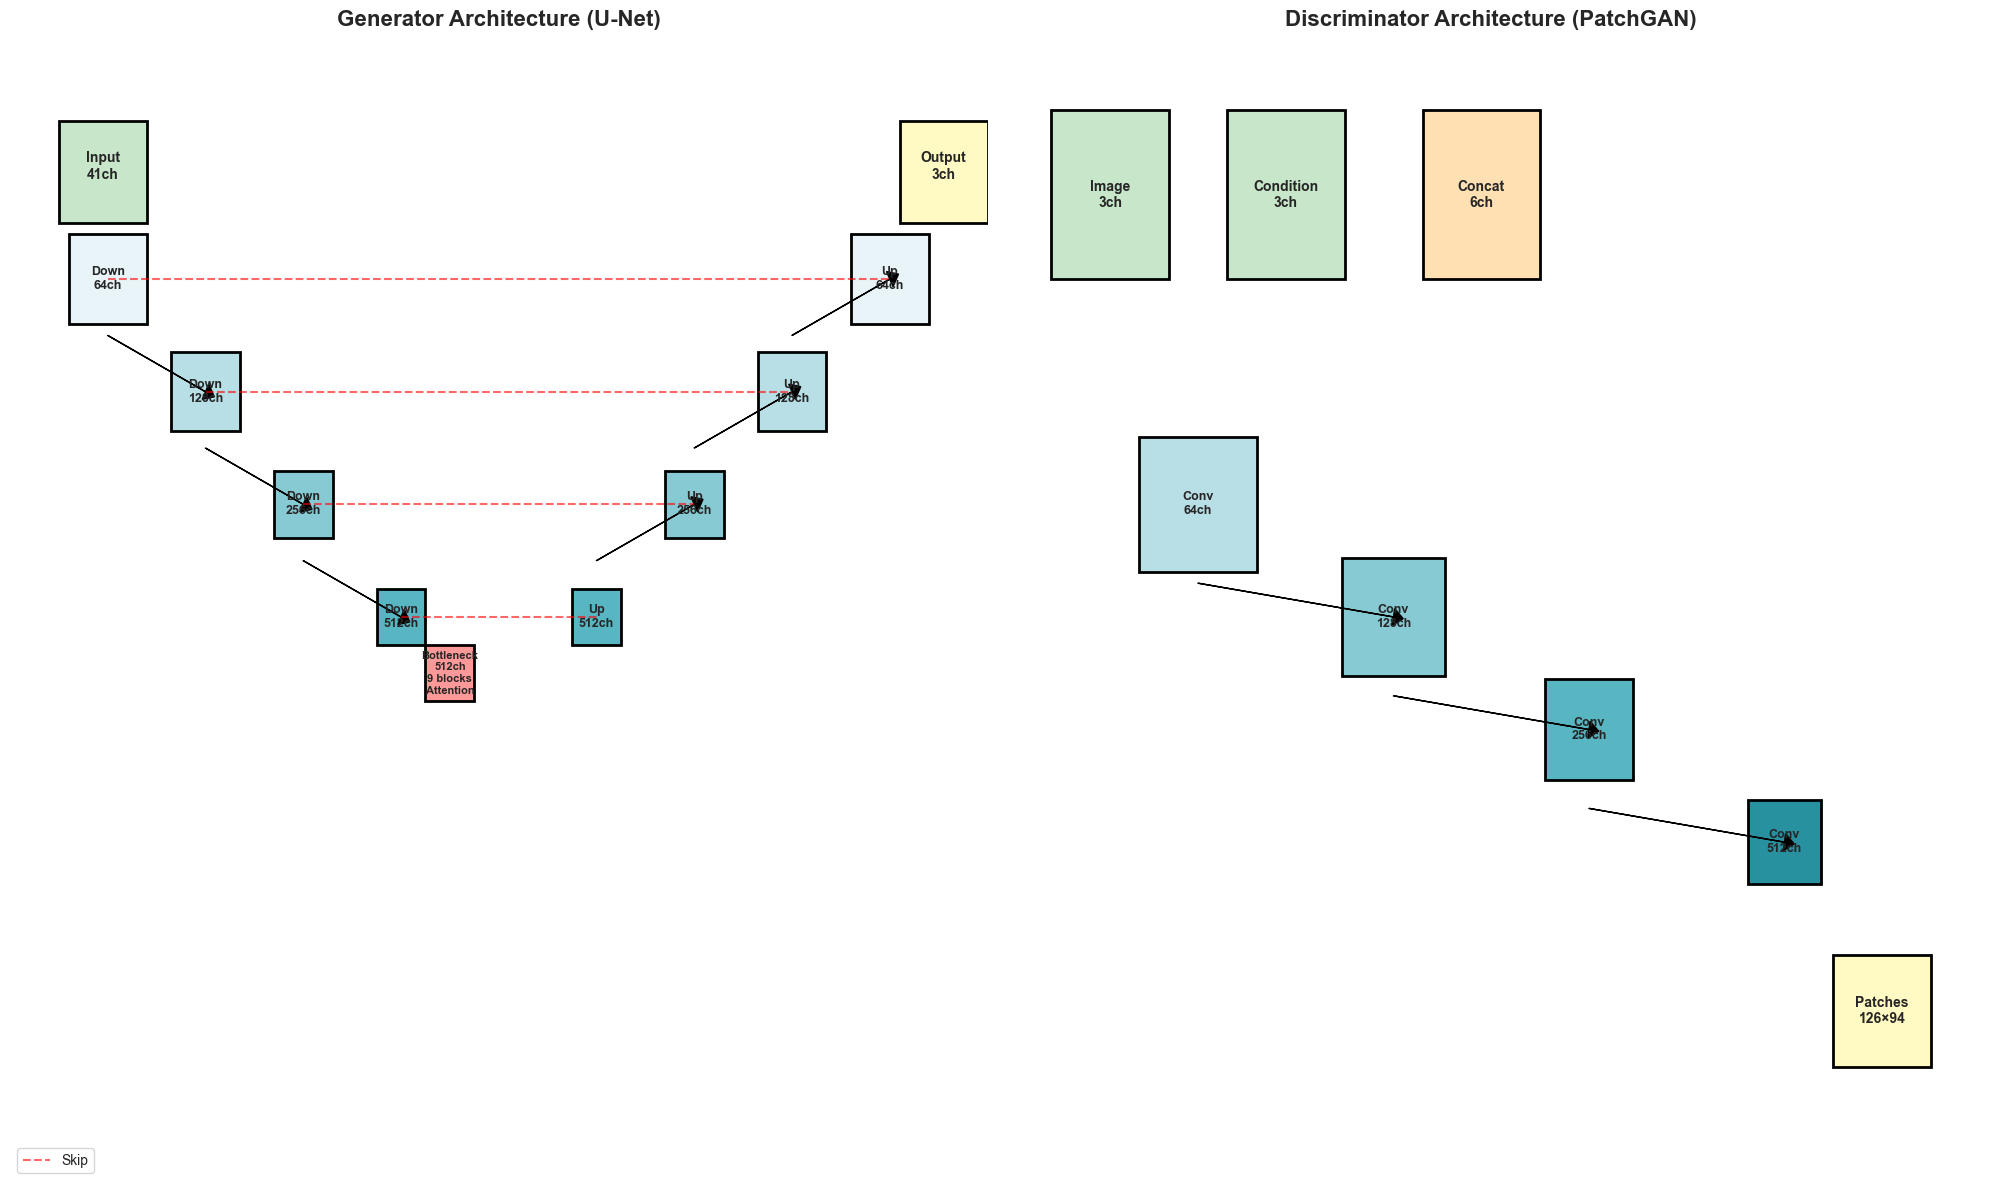

✅ Architecture visualization saved


In [13]:
def visualize_architecture():
    """
    Create visual diagram of model architecture.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
    
    # Generator U-Net visualization
    ax1.set_title('Generator Architecture (U-Net)', fontsize=16, fontweight='bold', pad=20)
    ax1.axis('off')
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    
    # Encoder path
    encoder_colors = ['#e8f4f8', '#b8dfe6', '#88cad4', '#58b5c2']
    encoder_positions = [(1, 8), (2, 7), (3, 6), (4, 5)]
    encoder_sizes = [(0.8, 0.8), (0.7, 0.7), (0.6, 0.6), (0.5, 0.5)]
    
    # Input
    ax1.add_patch(Rectangle((0.5, 8.5), 0.9, 0.9, 
                            facecolor='#c8e6c9', edgecolor='black', linewidth=2))
    ax1.text(0.95, 9.0, 'Input\n41ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Encoder blocks
    for i, (pos, size, color) in enumerate(zip(encoder_positions, encoder_sizes, encoder_colors)):
        channels = 64 * min(2**i, 8)
        ax1.add_patch(Rectangle((pos[0]-size[0]/2, pos[1]-size[1]/2), size[0], size[1],
                                facecolor=color, edgecolor='black', linewidth=2))
        ax1.text(pos[0], pos[1], f'Down\n{channels}ch', ha='center', va='center', 
                fontsize=9, fontweight='bold')
        # Arrow
        if i > 0:
            ax1.arrow(encoder_positions[i-1][0], encoder_positions[i-1][1]-0.5,
                     pos[0]-encoder_positions[i-1][0], pos[1]-encoder_positions[i-1][1]+0.5,
                     head_width=0.15, head_length=0.1, fc='black', ec='black')
    
    # Bottleneck
    ax1.add_patch(Rectangle((4.25, 4.25), 0.5, 0.5,
                            facecolor='#ff9999', edgecolor='black', linewidth=2))
    ax1.text(4.5, 4.5, 'Bottleneck\n512ch\n9 blocks\nAttention', 
            ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Decoder path
    decoder_positions = [(6, 5), (7, 6), (8, 7), (9, 8)]
    decoder_sizes = [(0.5, 0.5), (0.6, 0.6), (0.7, 0.7), (0.8, 0.8)]
    
    for i, (pos, size, color) in enumerate(zip(decoder_positions, decoder_sizes, 
                                               encoder_colors[::-1])):
        channels = 64 * min(2**(3-i), 8)
        ax1.add_patch(Rectangle((pos[0]-size[0]/2, pos[1]-size[1]/2), size[0], size[1],
                                facecolor=color, edgecolor='black', linewidth=2))
        ax1.text(pos[0], pos[1], f'Up\n{channels}ch', ha='center', va='center',
                fontsize=9, fontweight='bold')
        # Arrow
        if i > 0:
            ax1.arrow(decoder_positions[i-1][0], decoder_positions[i-1][1]+0.5,
                     pos[0]-decoder_positions[i-1][0], pos[1]-decoder_positions[i-1][1]-0.5,
                     head_width=0.15, head_length=0.1, fc='black', ec='black')
    
    # Output
    ax1.add_patch(Rectangle((9.1, 8.5), 0.9, 0.9,
                            facecolor='#fff9c4', edgecolor='black', linewidth=2))
    ax1.text(9.55, 9.0, 'Output\n3ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Skip connections (dashed lines)
    for enc_pos, dec_pos in zip(encoder_positions, decoder_positions[::-1]):
        ax1.plot([enc_pos[0], dec_pos[0]], [enc_pos[1], dec_pos[1]],
                'r--', linewidth=1.5, alpha=0.6, label='Skip' if enc_pos == encoder_positions[0] else '')
    
    ax1.legend(loc='lower left', fontsize=10)
    
    # Discriminator visualization
    ax2.set_title('Discriminator Architecture (PatchGAN)', fontsize=16, fontweight='bold', pad=20)
    ax2.axis('off')
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    
    # Input images
    ax2.add_patch(Rectangle((0.5, 8), 1.2, 1.5,
                            facecolor='#c8e6c9', edgecolor='black', linewidth=2))
    ax2.text(1.1, 8.75, 'Image\n3ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    ax2.add_patch(Rectangle((2.3, 8), 1.2, 1.5,
                            facecolor='#c8e6c9', edgecolor='black', linewidth=2))
    ax2.text(2.9, 8.75, 'Condition\n3ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Concatenate
    ax2.add_patch(Rectangle((4.3, 8), 1.2, 1.5,
                            facecolor='#ffe0b2', edgecolor='black', linewidth=2))
    ax2.text(4.9, 8.75, 'Concat\n6ch', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Conv layers
    disc_colors = ['#b8dfe6', '#88cad4', '#58b5c2', '#2891a0']
    disc_positions = [(2, 6), (4, 5), (6, 4), (8, 3)]
    disc_channels = [64, 128, 256, 512]
    
    for i, (pos, color, ch) in enumerate(zip(disc_positions, disc_colors, disc_channels)):
        size = 1.2 - i * 0.15
        ax2.add_patch(Rectangle((pos[0]-size/2, pos[1]-size/2), size, size,
                                facecolor=color, edgecolor='black', linewidth=2))
        ax2.text(pos[0], pos[1], f'Conv\n{ch}ch', ha='center', va='center',
                fontsize=9, fontweight='bold')
        # Arrow
        if i > 0:
            ax2.arrow(disc_positions[i-1][0], disc_positions[i-1][1]-0.7,
                     pos[0]-disc_positions[i-1][0], pos[1]-disc_positions[i-1][1]+0.7,
                     head_width=0.15, head_length=0.1, fc='black', ec='black')
    
    # Output
    ax2.add_patch(Rectangle((8.5, 1), 1.0, 1.0,
                            facecolor='#fff9c4', edgecolor='black', linewidth=2))
    ax2.text(9.0, 1.5, f'Patches\n{patch_h}×{patch_w}', 
            ha='center', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'model_architecture.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Architecture visualization saved")


visualize_architecture()

## 12. Save Model Configuration

In [14]:
# Create detailed model configuration
architecture_config = {
    'generator': {
        'type': 'U-Net',
        'input_channels': model_config['input_channels'],
        'output_channels': model_config['output_channels'],
        'base_channels': model_config['ngf'],
        'n_downsampling': model_config['n_downsampling'],
        'n_blocks': model_config['n_blocks'],
        'use_dropout': model_config['use_dropout'],
        'use_attention': model_config['use_attention'],
        'total_parameters': gen_total,
        'trainable_parameters': gen_trainable,
        'memory_mb': gen_total * 4 / 1024**2
    },
    'discriminator': {
        'type': 'PatchGAN',
        'input_channels': 6,
        'base_channels': model_config['ndf'],
        'n_layers': 3,
        'use_spectral_norm': True,
        'patch_size': '70x70',
        'output_patches': f'{patch_h}x{patch_w}',
        'total_parameters': disc_total,
        'trainable_parameters': disc_trainable,
        'memory_mb': disc_total * 4 / 1024**2
    },
    'total': {
        'combined_parameters': gen_total + disc_total,
        'combined_memory_mb': (gen_total + disc_total) * 4 / 1024**2
    },
    'image_size': model_config['image_size'],
    'device': device
}

# Save configuration
config_path = output_dir / 'model_architecture_config.json'
with open(config_path, 'w') as f:
    json.dump(architecture_config, f, indent=2)

print("="*70)
print("💾 MODEL CONFIGURATION SAVED")
print("="*70)

print(f"\n📄 Config saved to: {config_path}")

print(f"\n📊 Summary:")
print(f"   - Generator parameters: {gen_total:,}")
print(f"   - Discriminator parameters: {disc_total:,}")
print(f"   - Total parameters: {gen_total + disc_total:,}")
print(f"   - Total memory: {(gen_total + disc_total) * 4 / 1024**2:.2f} MB")

print("\n" + "="*70)

💾 MODEL CONFIGURATION SAVED

📄 Config saved to: d:\Projects\AI-Virtual-TryOn\outputs\model_architecture\model_architecture_config.json

📊 Summary:
   - Generator parameters: 63,847,812
   - Discriminator parameters: 2,766,913
   - Total parameters: 66,614,725
   - Total memory: 254.12 MB



## 13. Summary

In [15]:
print("="*70)
print("🎉 MODEL ARCHITECTURE COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Implemented building blocks (ResidualBlock, Attention, etc.)")
print("   2. ✓ Created Generator (U-Net with attention)")
print("   3. ✓ Created Discriminator (PatchGAN with spectral norm)")
print("   4. ✓ Initialized both models on GPU")
print("   5. ✓ Counted parameters and memory")
print("   6. ✓ Tested Generator forward pass")
print("   7. ✓ Tested Discriminator forward pass")
print("   8. ✓ Tested full pipeline")
print("   9. ✓ Visualized architecture")
print("   10. ✓ Saved model configuration")

print(f"\n📊 Model Statistics:")
print(f"   🔷 Generator:")
print(f"      - Architecture: U-Net with self-attention")
print(f"      - Input: [B, 41, 1024, 768]")
print(f"      - Output: [B, 3, 1024, 768]")
print(f"      - Parameters: {gen_total:,}")
print(f"      - Memory: {gen_total * 4 / 1024**2:.2f} MB")
print(f"   🔶 Discriminator:")
print(f"      - Architecture: PatchGAN with spectral normalization")
print(f"      - Input: [B, 6, 1024, 768] (image + condition)")
print(f"      - Output: [B, 1, {patch_h}, {patch_w}] (patch predictions)")
print(f"      - Parameters: {disc_total:,}")
print(f"      - Memory: {disc_total * 4 / 1024**2:.2f} MB")

print(f"\n📁 Generated Files:")
print(f"   - model_architecture.png")
print(f"   - model_architecture_config.json")

print("\n🚀 Ready for Next Steps:")
print("   1. Define loss functions (GAN, Perceptual, L1)")
print("   2. Implement training loop")
print("   3. Add checkpointing and logging")
print("   4. Start model training")

print("\n💡 Key Features:")
print("   - U-Net encoder-decoder architecture")
print("   - Skip connections for feature preservation")
print("   - Self-attention at bottleneck")
print("   - Residual blocks for stability")
print("   - PatchGAN discriminator (70×70)")
print("   - Spectral normalization for training stability")
print("   - Instance normalization throughout")

print("\n" + "="*70)

print("\n✅ MODEL ARCHITECTURE READY FOR TRAINING!")
print("="*70)

🎉 MODEL ARCHITECTURE COMPLETE!

✅ Completed Tasks:
   1. ✓ Implemented building blocks (ResidualBlock, Attention, etc.)
   2. ✓ Created Generator (U-Net with attention)
   3. ✓ Created Discriminator (PatchGAN with spectral norm)
   4. ✓ Initialized both models on GPU
   5. ✓ Counted parameters and memory
   6. ✓ Tested Generator forward pass
   7. ✓ Tested Discriminator forward pass
   8. ✓ Tested full pipeline
   9. ✓ Visualized architecture
   10. ✓ Saved model configuration

📊 Model Statistics:
   🔷 Generator:
      - Architecture: U-Net with self-attention
      - Input: [B, 41, 1024, 768]
      - Output: [B, 3, 1024, 768]
      - Parameters: 63,847,812
      - Memory: 243.56 MB
   🔶 Discriminator:
      - Architecture: PatchGAN with spectral normalization
      - Input: [B, 6, 1024, 768] (image + condition)
      - Output: [B, 1, 126, 94] (patch predictions)
      - Parameters: 2,766,913
      - Memory: 10.55 MB

📁 Generated Files:
   - model_architecture.png
   - model_architectu